# Project


Colorectal Liver Metastases Recurrence Prediction from Clinical and CT Image Data

# Preliminaries

In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import matplotlib.pyplot as plt
from torchvision import models
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Classification Dataset

In [67]:
config = {
    "batch_size": 16,
    "lr": 1e-2,
    "epochs": 30
}

Load datasets and data augmentation

You can download the datasets at https://drive.google.com/drive/folders/14mJNEYAsGXLe3F-6vi_TcOAe6t4DxCSY?usp=share_link

In [68]:
DATA_DIR    = '/content/drive/MyDrive/dataset/'
TRAIN_DIR   = os.path.join(DATA_DIR, "train") 
VAL_DIR     = os.path.join(DATA_DIR, "valid")


train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandAugment(6),
    # torchvision.transforms.RandomHorizontalFlip(),
    # torchvision.transforms.RandomRotation(10),
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.20978874], std=[0.21695834]),
])

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.20978874], std=[0.21695834])
])

train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform=valid_transforms)

# train_sub_idx = [i for i in range(len(train_dataset)) if train_dataset.imgs[i][0].split('/')[7] in train_cluster_name]
# train_sub_dataset = torch.utils.data.Subset(train_dataset, train_sub_idx)
# valid_sub_idx = [i for i in range(len(valid_dataset)) if valid_dataset.imgs[i][0].split('/')[7] in valid_cluster_name]
# valid_sub_dataset = torch.utils.data.Subset(valid_dataset, valid_sub_idx)

Create WeightedRandomSampler for imbalanced dataset

In [69]:
list_name=[]
list_label=[]
for i,j in train_dataset.imgs:
  list_name.append(i)
  list_label.append(j)
from torch.utils.data import WeightedRandomSampler
labels_unique,counts = np.unique(np.array(list_label),return_counts=True)
class_weights = [sum(counts)/c for c in counts]
example_weights = [class_weights[e] for e in list_label ]
sampler = WeightedRandomSampler(example_weights,len(list_label))

In [71]:
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset, 
    batch_size  = config['batch_size'], 
    #shuffle     = True,
    num_workers = 4, 
    sampler = sampler,
    pin_memory  = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset     = valid_dataset, 
    batch_size  = config['batch_size'],
    shuffle     = False,
    #sampler = sampler,
    num_workers = 2
)

# Model

Model 1, ConvNext Model

In [40]:
# Reference: https://arxiv.org/abs/2201.03545(github: https://github.com/facebookresearch/ConvNeXt) 
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv1 = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.bn1 = nn.BatchNorm2d(dim)
        self.conv2 = nn.Conv2d(dim, dim*4, kernel_size= 1, stride= 1, padding= 0)
        self.gelu = nn.GELU()
        self.conv3 = nn.Conv2d(4*dim, dim, kernel_size= 1, stride= 1, padding= 0)
    
    def forward(self, x):
        self.input = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.gelu(x)
        x = self.conv3(x)
        return x + self.input
    
class ConvNeXt_L(nn.Module):
    def __init__(self, in_channels= 1, num_class= 1, depths= [3, 3, 27, 3], dims = [96, 192, 384, 768]):
        super().__init__()
        self.downsample_layers = nn.ModuleList()
        self.stage_layers = nn.ModuleList()
        self.cls_layer = nn.Linear(dims[-1], num_class)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flat = nn.Flatten()
        self.dropout = nn.Dropout(p = 0.1)
        
        self.stem_layer = nn.Sequential(
            nn.Conv2d(in_channels, dims[0], kernel_size= 4, stride= 4),
            nn.BatchNorm2d(dims[0])
        )
        self.downsample_layers.append(self.stem_layer)
        
        for i in range(3):
            downsample_layer = nn.Sequential(
                nn.BatchNorm2d(dims[i]),
                nn.Conv2d(dims[i], dims[i+1], kernel_size= 2, stride= 2)
            )
            self.downsample_layers.append(downsample_layer)
            
        for i in range(4):
            stage_layer = nn.Sequential(
                *[Block(dim= dims[i]) for k in range(depths[i])]
            )
            self.stage_layers.append(stage_layer)
        
    def forward(self, x, return_feats=False):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stage_layers[i](x)
        x = self.avgpool(x)
        x = self.flat(x)
        x = self.dropout(x)
        
        if return_feats:
            return x
        else:
            return self.cls_layer(x)
        
model = ConvNeXt_L().to(DEVICE)
summary(model, (1, 224, 224))

In [ ]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):

    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

In [ ]:
def resnet34():
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock, [3, 4, 6, 3])
model = resnet34().to(DEVICE)
summary(model, (1, 224, 224))

Model3, VGG-B model

In [73]:
cfg = {
    'A' : [64,     'M', 128,      'M', 256, 256,           'M', 512, 512,           'M', 512, 512,           'M'],
    'B' : [64, 64, 'M', 128, 128, 'M', 256, 256,           'M', 512, 512,           'M', 512, 512,           'M'],
    'D' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256,      'M', 512, 512, 512,      'M', 512, 512, 512,      'M'],
    'E' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

class VGG(nn.Module):

    def __init__(self, features, num_class=1):
        super().__init__()
        self.features = features

        self.classifier = nn.Sequential(
            #nn.Linear(25088, 4096),
            nn.Linear(25088,8),
            # nn.Sigmoid(),
            nn.ReLU(),
            nn.Dropout(),
            #nn.Linear(4096, 4096),
            nn.Linear(8,8),
            # nn.Sigmoid(),
            nn.ReLU(),
            nn.Dropout(),
            #nn.Linear(4096, num_class)
            nn.Linear(8, num_class)
        )

    def forward(self, x):
        output = self.features(x)
        output = output.view(output.size()[0], -1)
        output = self.classifier(output)

        return output

def make_layers(cfg, batch_norm=False):
    layers = []

    input_channel = 1
    for l in cfg:
        if l == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            continue

        layers += [nn.Conv2d(input_channel, l, kernel_size=3, padding=1)]

        if batch_norm:
            layers += [nn.BatchNorm2d(l)]

        # layers += [nn.Sigmoid()]
        layers += [nn.ReLU(inplace=True)]
        input_channel = l

    return nn.Sequential(*layers)

model = VGG(make_layers(cfg['B'], batch_norm=True)).to(DEVICE)
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

# Setup everything for training

In [74]:
criterion = torch.nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'max',factor=0.5, patience=2)

# Let's train!

In [76]:
import torch.nn.functional as F
def train(model, dataloader, optimizer, criterion):
    
    model.train()

    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5) 

    total_loss  = 0.0
    num_correct = 0

    for i, (images, labels) in enumerate(dataloader):
        
        optimizer.zero_grad()
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        outputs = model(images)
        loss    = criterion(outputs, labels.unsqueeze(1).float())

        pred = torch.tensor([1 if x > 0.75 else 0 for x in F.sigmoid(outputs)])
        pred = pred.to(DEVICE)
        num_correct     += int((pred == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )
        
        loss.backward()
        optimizer.step()
      
        batch_bar.update()

    batch_bar.close()

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [77]:
def validate(model, dataloader, criterion):
  
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    total_loss = 0.0
    num_correct = 0.0
    test_results = []
    true_labels = []

    for i, (images, labels) in enumerate(dataloader):

        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.inference_mode():
            outputs = model(images)
            loss    = criterion(outputs, labels.unsqueeze(1).float())

        pred = F.sigmoid(outputs)
        pred = torch.tensor([1 if x > 0.75 else 0 for x in pred]).to(DEVICE)
        num_correct     += int((pred == labels).sum())
        total_loss += float(loss.item())


        opts = pred.detach().cpu().numpy().tolist()
        labels = labels.detach().cpu().numpy().tolist()
        test_results.extend(opts)
        true_labels.extend(labels)

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))))

        batch_bar.update()
        
    batch_bar.close()


    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    
    return acc, total_loss,test_results, true_labels

In [78]:
gc.collect()
torch.cuda.empty_cache()

# Experiments

In [79]:
best_valacc = 0

for epoch in range(config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    
    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        curr_lr))
    
    val_acc, val_loss,test_results, true_labels = validate(model, valid_loader, criterion)
    
    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))
    scheduler.step(val_acc)


    # if val_acc >= best_valacc:
    #   #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
    #   print("Saving model")
    #   torch.save({'model_state_dict':model.state_dict(),
    #               'optimizer_state_dict':optimizer.state_dict(),
    #               #'scheduler_state_dict':scheduler.state_dict(),
    #               'val_acc': val_acc, 
    #               'epoch': epoch}, '/content/drive/MyDrive/mlproj_base1.pth')
    #   best_valacc = val_acc


Epoch 1/30: 
Train Acc 50.3289%	 Train Loss 0.6956	 Learning Rate 0.1000


Val Acc 61.8976%	 Val Loss 0.6973



Epoch 2/30: 
Train Acc 49.7880%	 Train Loss 0.6937	 Learning Rate 0.1000


Val Acc 61.8976%	 Val Loss 0.6806



Epoch 3/30: 
Train Acc 50.3509%	 Train Loss 0.6934	 Learning Rate 0.1000


Val Acc 61.8976%	 Val Loss 0.6809



Epoch 4/30: 
Train Acc 50.4167%	 Train Loss 0.6938	 Learning Rate 0.1000


Val Acc 61.8976%	 Val Loss 0.6905



Epoch 5/30: 
Train Acc 50.1316%	 Train Loss 0.6932	 Learning Rate 0.0500


Val Acc 61.8976%	 Val Loss 0.6887



Epoch 6/30: 
Train Acc 48.8304%	 Train Loss 0.6932	 Learning Rate 0.0500


Val Acc 61.8976%	 Val Loss 0.6973



Epoch 7/30: 
Train Acc 50.5044%	 Train Loss 0.6934	 Learning Rate 0.0500


Val Acc 61.8976%	 Val Loss 0.6896


Train:  95%|█████████▍| 810/855 [01:07<00:03, 11.54it/s, acc=50.1543%, loss=0.6933, lr=0.0250]

KeyboardInterrupt: ignored

# Model validation

confusion matrix

Text(83.22222222222221, 0.5, 'Predicted class')

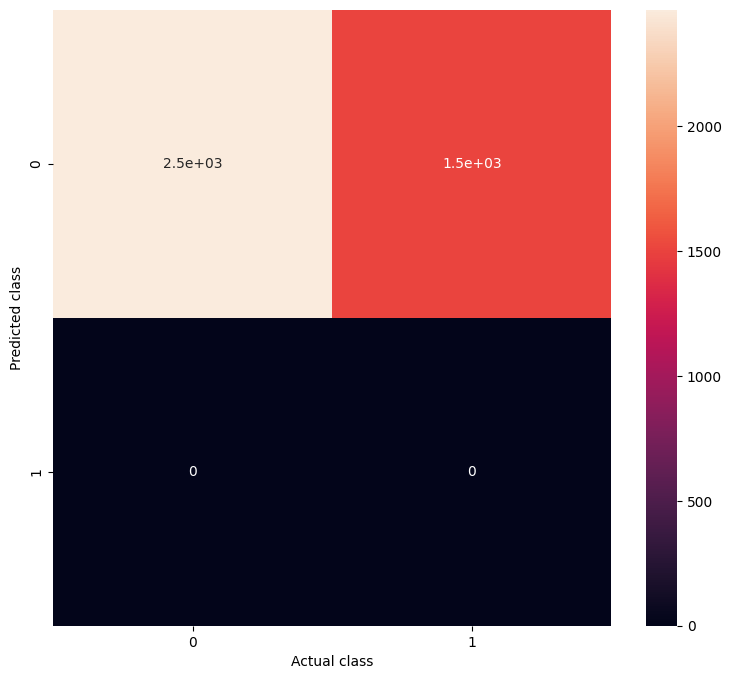

In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# test_results, true_labels = test(model, valid_loader, criterion)

cm = confusion_matrix(test_results, true_labels)
plt.figure(figsize=(9, 8))
sns.heatmap(cm, annot=True)
plt.xlabel("Actual class")
plt.ylabel("Predicted class")

F1 score

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(true_labels, test_results)

# Print F1 score
print("F1 score:", f1)

F1 score: 0.0


# Re-analysis

PCA and Kmeans clustering

In [ ]:
import os
import numpy as np
from sklearn.cluster import KMeans
import cv2
from imutils import build_montages
import matplotlib.image as imgplt


DATA_DIR    = '/content/drive/MyDrive/dataset/'
TRAIN_DIR   = os.path.join(DATA_DIR, "train/0") 
VAL_DIR     = os.path.join(DATA_DIR, "valid/0")

# load data for class 0 and class 1 in training set
dir0 = os.path.join(DATA_DIR, "train/0") 

image_path = []
all_images = []
images = os.listdir(dir)

for image_name in images:
    image_path.append(dir+'/' + image_name)
for path in image_path:
    image = imgplt.imread(path)
    image = image.reshape(-1, )
    all_images.append(image)

dir1 = os.path.join(DATA_DIR, "train/1") 

image_path = []
all_images1 = []
images = os.listdir(dir)

for image_name in images:
    image_path.append(dir+'/' + image_name)
for path in image_path:
    image = imgplt.imread(path)
    image = image.reshape(-1, )
    all_images1.append(image)

train_0_array = np.array(all_images)
train_1_array = np.array(all_images1)

PCA for image features dimension reducion

In [ ]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# class 0
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(train_0_array)
pca = PCA(n_components=2)
pca_data_0 = pca.fit_transform(normalized_data)
clt = KMeans(n_clusters=5)
clt.fit(pca_data_0)
clusters_train_0 = clt.predict(pca_data_0)

# class 1
normalized_data = scaler.fit_transform(train_1_array)
pca = PCA(n_components=2)
pca_data_1 = pca.fit_transform(normalized_data)
clt = KMeans(n_clusters=5)
clt.fit(pca_data_1)
clusters_train_1 = clt.predict(pca_data_1)

In [ ]:
# clusterin results plotting
fig, ax = plt.subplots()

scatter1 = ax.scatter(pca_data_0[:,0], pca_data_0[:,1],s=5, c=clusters_train_0, marker = '*',cmap='Accent',alpha=0.5)
scatter2 = ax.scatter(pca_data_1[:,0], pca_data_1[:,1],s=5, c=clusters_train_1, marker = 'o',cmap='Accent',alpha=0.5)

# add labels and title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering Results-c;')
legend1 = ax.legend(*scatter1.legend_elements(), loc="upper left", title="Clusters-Class 0")
legend2 = ax.legend(*scatter2.legend_elements(), loc="upper right", title="Clusters-Class 1")
ax.add_artist(legend1)
ax.add_artist(legend2)

# show the plot
plt.show()